In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 11:31:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/30 11:31:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Import

In [3]:
df_boxscore = spark.read.csv("data/boxscore.csv", header=True, inferSchema=True)
df_games = spark.read.csv("data/games.csv", header=True, inferSchema=True)
df_salaries = spark.read.csv("data/salaries.csv", header=True, inferSchema=True)
df_playerInfo = spark.read.csv("data/player_info.csv", header=True, inferSchema=True)

In [4]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

741569 30250 11583 5018


In [5]:
df_boxscore.show(5)

+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|        teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      1|Sacramento Kings|Corliss Williamson|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|
|      1|Sacramento Kings|    Mitch Richmond|32:00|  6| 12|  1|  4|  1|  1|  0|  5|  5|  3|  1|  2|  3|  1| 14|-12|        1|
|      1|Sacramento Kings|    Olden Polynice|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|
|      1|Sacramento Kings|Mahmoud Abdul-Rauf|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|
|      1|Sacramento Kings|       Brian Grant|25:13|  3| 11|  0|  0|  2|  2|  1|  5|  6|  0|  0|  2|  1|  2|  8| -7|   

In [6]:
df_games.show(5)

+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|seasonStartYear|            awayTeam|pointsAway|            homeTeam|pointsHome|attendance|notes|startET|  datetime|isRegular|game_id|
+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|           1996|    Sacramento Kings|        85|     Houston Rockets|        96|   16285.0| NULL|   NULL|1996-11-01|        1|      1|
|           1996|Los Angeles Clippers|        97|Golden State Warr...|        85|   15593.0| NULL|   NULL|1996-11-01|        1|      2|
|           1996|Portland Trail Bl...|       114| Vancouver Grizzlies|        85|   19193.0| NULL|   NULL|1996-11-01|        1|      3|
|           1996| Seattle SuperSonics|        91|           Utah Jazz|        99|   19911.0| NULL|   NULL|1996-11-01|        1|      4|
|           1996|     New York Knicks|       107

In [7]:
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|  Michael Jordan|           1996|$30,140,000|       $52,258,566|
|    Horace Grant|           1996|$14,857,000|       $25,759,971|
|   Reggie Miller|           1996|$11,250,000|       $19,505,934|
|Shaquille O'Neal|           1996|$10,714,000|       $18,576,585|
|     Gary Payton|           1996|$10,212,000|       $17,706,187|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



In [8]:
df_playerInfo.show(5)

+--------------------+----+----+---+----+-----+----------------+--------------------+
|          playerName|From|  To|Pos|  Ht|   Wt|       birthDate|            Colleges|
+--------------------+----+----+---+----+-----+----------------+--------------------+
|      Alaa Abdelnaby|1991|1995|F-C|6-10|240.0|   June 24, 1968|                Duke|
|     Zaid Abdul-Aziz|1969|1978|C-F| 6-9|235.0|   April 7, 1946|          Iowa State|
|Kareem Abdul-Jabbar*|1970|1989|  C| 7-2|225.0|  April 16, 1947|                UCLA|
|  Mahmoud Abdul-Rauf|1991|2001|  G| 6-1|162.0|   March 9, 1969|                 LSU|
|   Tariq Abdul-Wahad|1998|2003|  F| 6-6|223.0|November 3, 1974|Michigan, San Jos...|
+--------------------+----+----+---+----+-----+----------------+--------------------+
only showing top 5 rows



# removing columns and dates

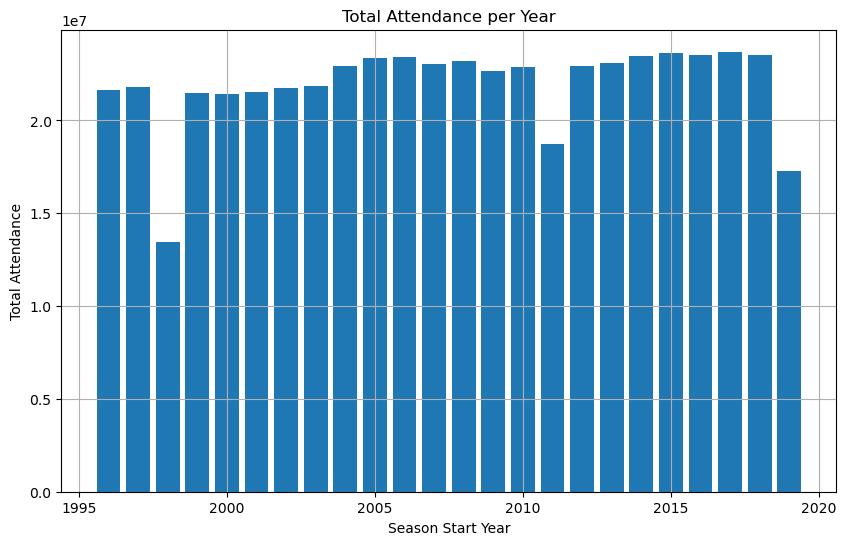

In [9]:
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt

df_sum = df_games.groupBy("seasonStartYear").agg(sum("attendance").alias("total_attendance"))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df_sum = df_sum.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pandas_df_sum["seasonStartYear"], pandas_df_sum["total_attendance"])
plt.title("Total Attendance per Year")
plt.xlabel("Season Start Year")
plt.ylabel("Total Attendance")
plt.grid(True)
plt.show()

In [10]:
#removing notes and startET from df_games
columns_to_drop = ["awayTeam", "pointsAway", "homeTeam", "pointsHome", "attendance", "notes", "startET", "datetime"]

# Drop the specified columns
df_games = df_games.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           1996|        1|      1|
|           1996|        1|      2|
|           1996|        1|      3|
|           1996|        1|      4|
|           1996|        1|      5|
+---------------+---------+-------+
only showing top 5 rows



In [11]:
df_games = df_games.filter((col("seasonStartYear") >= 2000) & (col("seasonStartYear") <= 2010))
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           2000|        1|   4577|
|           2000|        1|   4578|
|           2000|        1|   4579|
|           2000|        1|   4580|
|           2000|        1|   4581|
+---------------+---------+-------+
only showing top 5 rows



In [12]:
df_salaries = df_salaries.filter((col("seasonStartYear") >= 2000) & (col("seasonStartYear") <= 2010))
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|   Kevin Garnett|           2000|$19,610,000|       $30,904,632|
|Shaquille O'Neal|           2000|$19,285,715|       $30,393,570|
| Alonzo Mourning|           2000|$16,880,000|       $26,602,253|
|    Juwan Howard|           2000|$16,875,000|       $26,594,373|
| Hakeem Olajuwon|           2000|$16,700,000|       $26,318,580|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



In [13]:
#game_id that are played between 2000 and 2010
selected_game_ids = df_games.select("game_id").distinct()

#filter salaries based on game_id

df_boxscore = df_boxscore.join(selected_game_ids, "game_id")

df_boxscore.show(5)

+-------+-------------------+-------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|           teamName|   playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+-------------------+-------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|   4577|Seattle SuperSonics|  Gary Payton|48:00| 10| 26|  2|  9|  5|  7|  4| 10| 14| 10|  1|  0|  6|  4| 27| -6|        1|
|   4577|Seattle SuperSonics|    Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|
|   4577|Seattle SuperSonics|Patrick Ewing|36:36|  1|  6|  0|  0|  0|  0|  2| 10| 12|  2|  0|  2|  3|  4|  2|-15|        1|
|   4577|Seattle SuperSonics|Rashard Lewis|34:32|  3| 10|  2|  5|  3|  4|  1|  4|  5|  1|  1|  0|  3|  5| 11| -4|        1|
|   4577|Seattle SuperSonics|Desmond Mason|17:01|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|
+-------

In [14]:
df_playerInfo = df_playerInfo.withColumn("From", df_playerInfo["From"].cast("int"))
df_playerInfo = df_playerInfo.withColumn("To", df_playerInfo["To"].cast("int"))

# Filter rows where the player played between 2000 and 2010
df_playerInfo = df_playerInfo.filter((col("From") >= 2000) & (col("To") <= 2010))

# Show the resulting DataFrame
df_playerInfo.show()

+--------------------+----+----+---+----+-----+-----------------+--------------------+
|          playerName|From|  To|Pos|  Ht|   Wt|        birthDate|            Colleges|
+--------------------+----+----+---+----+-----+-----------------+--------------------+
|          Alex Acker|2006|2009|  G| 6-5|185.0| January 21, 1983|          Pepperdine|
|        Hassan Adams|2007|2009|  G| 6-4|220.0|    June 20, 1984|             Arizona|
|  Courtney Alexander|2001|2003|  G| 6-5|205.0|   April 27, 1977|Virginia, Fresno ...|
|       Joe Alexander|2009|2010|  F| 6-8|230.0|December 26, 1986|       West Virginia|
|        Lance Allred|2008|2008|  C|6-11|250.0| February 2, 1981|   Utah, Weber State|
|        Rafer Alston|2000|2010|  G| 6-2|171.0|    July 24, 1976|        Fresno State|
|    Antonio Anderson|2010|2010|  G| 6-6|215.0|     June 5, 1985|             Memphis|
|Martynas Andriušk...|2006|2006|  C| 7-2|240.0|   March 12, 1986|                NULL|
|       Rafael Araújo|2005|2007|  C|6-11|28

In [15]:
#for the moment, in df_playerInfo we will not drop the rows that contains player that did not played in between 2000-2010
#because we will do it later with a join

#removing notes and startET from df_games
columns_to_drop = ["From", "To", "birthDate", "Colleges"]

# Drop the specified columns
df_playerInfo = df_playerInfo.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_playerInfo.show(5)

+------------------+---+----+-----+
|        playerName|Pos|  Ht|   Wt|
+------------------+---+----+-----+
|        Alex Acker|  G| 6-5|185.0|
|      Hassan Adams|  G| 6-4|220.0|
|Courtney Alexander|  G| 6-5|205.0|
|     Joe Alexander|  F| 6-8|230.0|
|      Lance Allred|  C|6-11|250.0|
+------------------+---+----+-----+
only showing top 5 rows



In [16]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

341806 14264 5098 377


# Missing values

In [17]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|teamName|playerName| MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0| 19|        0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+



In [18]:
#visualize the rows with +/- equal to NULL
rows_with_null = df_boxscore.filter(
    (col("+/-").isNull()))

rows_with_null.show()


+-------+--------------------+--------------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|game_id|            teamName|          playerName|  MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS| +/-|isStarter|
+-------+--------------------+--------------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|   5026|       Orlando Magic|            Don Reid|1:00|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   6348|  Los Angeles Lakers|Stanislav Medvedenko|1:00|  0|  0|  0|  0|  0|  2|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   6844|     Detroit Pistons|    Victor Alexander|1:00|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   7125|Los Angeles Clippers|         Wang Zhizhi|1:06|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|   7153| Cleveland Cavaliers|     Michael Stewart|2:00|  0|  0|  0|  0|  0|

In [19]:
#visualize the rows with +/- equal to 0
filtered_rows = df_boxscore.filter(col("+/-") == "0")

filtered_rows.show(20)


+-------+--------------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|            teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|   4577| Seattle SuperSonics|         Vin Baker|37:28|  7| 16|  0|  0|  5|  6|  2|  5|  7|  1|  1|  4|  3|  3| 19|  0|        1|
|   4577| Seattle SuperSonics|      Jelani McCoy| 4:37|  0|  0|  0|  0|  0|  0|  0|  1|  1|  1|  0|  0|  0|  0|  0|  0|        0|
|   4577| Vancouver Grizzlies|       Damon Jones| 7:27|  1|  4|  1|  2|  0|  0|  1|  1|  2|  1|  0|  0|  0|  0|  3|  0|        0|
|   4578|       Orlando Magic|      John Amaechi|25:32|  6| 10|  0|  0|  2|  4|  0|  3|  3|  1|  1|  1|  2|  4| 14|  0|        1|
|   4579|     Milwaukee Bucks|      Rafer Alston| 0:20|  0|  0|  0|  0|  0|  0|  1|  0|  1

In [20]:
#remove the columns with nulls
df_boxscore = df_boxscore.filter(col("+/-").isNotNull())

In [21]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|teamName|playerName| MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|        0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+



In [22]:
from pyspark.sql.functions import col,isnan, when, count
df_salaries.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_salaries.columns]
   ).show()

+----------+---------------+------+------------------+
|playerName|seasonStartYear|salary|inflationAdjSalary|
+----------+---------------+------+------------------+
|         0|              0|     0|                 0|
+----------+---------------+------+------------------+



In [23]:
# Create a list comprehension to count null or NaN values for each column
counts_expr = [count(when(col(c).isNull(), c)).alias(c) if c != 'datetime' else count(when(col(c).isNull(), c)).alias(c+'_null_count') for c in df_games.columns]

# Apply the counts expression to the DataFrame
df_games.select(counts_expr).show()

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|              0|        0|      0|
+---------------+---------+-------+



In [24]:
from pyspark.sql.functions import col,isnan, when, count
df_playerInfo.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_playerInfo.columns]
   ).show()

+----------+---+---+---+
|playerName|Pos| Ht| Wt|
+----------+---+---+---+
|         0|  0|  0|  0|
+----------+---+---+---+



In [25]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

341787 14264 5098 377


## Joins

In [26]:
#join boxscore and games (for the insertion of the data and the isRegular)
df_boxscore = df_boxscore.join(df_games, "game_id")
df_boxscore.show(20)

+-------+-------------------+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+---------------+---------+
|game_id|           teamName|         playerName|           MP|           FG|          FGA|           3P|          3PA|           FT|          FTA|          ORB|          DRB|          TRB|          AST|          STL|          BLK|          TOV|           PF|          PTS|          +/-|isStarter|seasonStartYear|isRegular|
+-------+-------------------+-------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+---------------+---------+
|   4577|Seattle SuperSonics

In [27]:
#join boxscore and player_info (for the insertion of the Position, Ht and Wt)
df_boxscore = df_boxscore.join(df_playerInfo, "playerName")
df_boxscore.show(20)

23/11/30 11:32:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-------+--------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------+---------------+---------+---+----+-----+
|        playerName|game_id|            teamName|          MP|          FG|         FGA|          3P|         3PA|          FT|         FTA|         ORB|         DRB|         TRB|         AST|         STL|         BLK|         TOV|          PF|         PTS|         +/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|
+------------------+-------+--------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------+---------------+---------+---+----+-----+
|     Desmond Mason|   4577| Seatt

In [28]:
player_occurrences = df_boxscore.groupBy("playerName").count()

# Show the result
player_occurrences.show()

+-----------------+-----+
|       playerName|count|
+-----------------+-----+
|    Kosta Perović|   23|
|       Lee Nailon|  405|
|   Marcus Haislip|  206|
|   Viktor Khryapa|  201|
|      Aaron Miles|   33|
|        Mile Ilić|   26|
|   Mike Penberthy|   59|
|         Art Long|  131|
|     Jeryl Sasser|  102|
|      Devin Brown|  578|
|Jermareo Davidson|  109|
|     Keith McLeod|  230|
|      Alvin Jones|   36|
|     Wayne Simien|  118|
|  Randolph Morris|  203|
|      Cheikh Samb|   54|
|     Nathan Jawai|   67|
|      Mark Blount|  736|
|        Mike Hall|    5|
|Kenny Satterfield|  120|
+-----------------+-----+
only showing top 20 rows



In [29]:
#output_path = "data/df_boxscore_2000-2010"
#df_boxscore.write.csv(output_path, header=True, mode="overwrite")

In [30]:
print(df_boxscore.count(), df_salaries.count())

58233 5098


# managing data types

In [31]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- MP: string (nullable = true)
 |-- FG: string (nullable = true)
 |-- FGA: string (nullable = true)
 |-- 3P: string (nullable = true)
 |-- 3PA: string (nullable = true)
 |-- FT: string (nullable = true)
 |-- FTA: string (nullable = true)
 |-- ORB: string (nullable = true)
 |-- DRB: string (nullable = true)
 |-- TRB: string (nullable = true)
 |-- AST: string (nullable = true)
 |-- STL: string (nullable = true)
 |-- BLK: string (nullable = true)
 |-- TOV: string (nullable = true)
 |-- PF: string (nullable = true)
 |-- PTS: string (nullable = true)
 |-- +/-: string (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)



In [32]:
# Assuming df_boxscore is your DataFrame
columns_to_check = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers, and filter out the rows where the conversion fails
converted_df = df_boxscore.select(
    "*",
    *[col(c).cast("int").isNotNull().alias(c+"_is_int") for c in columns_to_check]
)

# Show the rows where conversion to integer failed
failed_conversion_rows = converted_df.filter(~col("FG_is_int") | ~col("FGA_is_int") |
                                              ~col("3P_is_int") | ~col("3PA_is_int") | ~col("FT_is_int") |
                                              ~col("FTA_is_int") | ~col("ORB_is_int") | ~col("DRB_is_int") |
                                              ~col("TRB_is_int") | ~col("AST_is_int") | ~col("STL_is_int") |
                                              ~col("BLK_is_int") | ~col("TOV_is_int") | ~col("PF_is_int") |
                                              ~col("PTS_is_int") | ~col("+/-_is_int"))

# Count the rows where conversion to integer failed
failed_conversion_count = failed_conversion_rows.count()

# Display the count and the first few rows where the conversion to integer failed
print("Number of rows with non-convertible string values:", failed_conversion_count)



Number of rows with non-convertible string values: 16600


In [33]:

# Assuming df_boxscore is your DataFrame
columns_to_convert = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers and drop rows where conversion is not possible
for column in columns_to_convert:
    df_boxscore = df_boxscore.withColumn(column, col(column).cast("int"))

# Drop rows where any of the specified columns is null after conversion
df_boxscore = df_boxscore.dropna(subset=columns_to_convert)

# Show the first few rows after conversion and removal of rows with non-convertible values
df_boxscore.show(20)


+----------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|      playerName|game_id|            teamName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|
+----------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|   Desmond Mason|   4577| Seattle SuperSonics|17:01|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|           2000|        1|  F| 6-7|224.0|
|Rubén Wolkowyski|   4577| Seattle SuperSonics|11:47|  0|  4|  0|  0|  0|  0|  1|  1|  2|  0|  0|  1|  0|  1|  0| -2|        0|           2000|        1|  F|6-10|270.0|
|  Stromile Swift|   4577| Vancouver Grizzlies| 8:54|  0|  1|  0|  0|  0|  0|  1|  0|  1|  0|  0|  0|  0|  0|  0|  7|        0|           2000|        1|  

In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Assuming df_boxscore is your DataFrame
def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Create a user-defined function (UDF) for the conversion
convert_to_seconds_udf = udf(convert_to_seconds, IntegerType())

# Apply the UDF to the "MP" column and create a new "MP_seconds" column
df_boxscore = df_boxscore.withColumn("MP_seconds", convert_to_seconds_udf(col("MP")))

# Show the DataFrame with the new "MP_seconds" column
df_boxscore.show(20)


+----------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|      playerName|game_id|            teamName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|
+----------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|   Desmond Mason|   4577| Seattle SuperSonics|17:01|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|           2000|        1|  F| 6-7|224.0|      1021|
|Rubén Wolkowyski|   4577| Seattle SuperSonics|11:47|  0|  4|  0|  0|  0|  0|  1|  1|  2|  0|  0|  1|  0|  1|  0| -2|        0|           2000|        1|  F|6-10|270.0|       707|
|  Stromile Swift|   4577| Vancouver Grizzlies| 8:54|  0|  1|  0|  0|  0|  0|  1|  0|  1|  0|  0|  0

In [35]:
#removing notes and startET from df_games
columns_to_drop = ["MP"]

# Drop the specified columns
df_boxscore = df_boxscore.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_boxscore.show(5)

+----------------+-------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|      playerName|game_id|           teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|
+----------------+-------+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|   Desmond Mason|   4577|Seattle SuperSonics|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|           2000|        1|  F| 6-7|224.0|      1021|
|Rubén Wolkowyski|   4577|Seattle SuperSonics|  0|  4|  0|  0|  0|  0|  1|  1|  2|  0|  0|  1|  0|  1|  0| -2|        0|           2000|        1|  F|6-10|270.0|       707|
|  Stromile Swift|   4577|Vancouver Grizzlies|  0|  1|  0|  0|  0|  0|  1|  0|  1|  0|  0|  0|  0|  0|  0|  7|        0|           2000

In [36]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+
|playerName|game_id|teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos| Ht| Wt|MP_seconds|
+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+
|         0|      0|       0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|        0|              0|        0|  0|  0|  0|         0|
+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+



In [37]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)
 |-- MP_seconds: integer (nullable = true)



In [38]:
print(df_boxscore.count(), df_salaries.count())

41633 5098


In [39]:
# Role cleaning and pre-processing
from pyspark.sql.functions import split, element_at

# Split the "name" column by space and select the first element
df_boxscore = df_boxscore.withColumn("pos_clean", element_at(split(df_boxscore["Pos"], "-"), 1))

# Show the updated DataFrame
df_boxscore.show()

+----------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+---------+
|      playerName|game_id|            teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|pos_clean|
+----------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+---------+
|   Desmond Mason|   4577| Seattle SuperSonics|  3|  9|  0|  3|  1|  2|  3|  2|  5|  2|  0|  1|  1|  5|  7|-15|        1|           2000|        1|  F| 6-7|224.0|      1021|        F|
|Rubén Wolkowyski|   4577| Seattle SuperSonics|  0|  4|  0|  0|  0|  0|  1|  1|  2|  0|  0|  1|  0|  1|  0| -2|        0|           2000|        1|  F|6-10|270.0|       707|        F|
|  Stromile Swift|   4577| Vancouver Grizzlies|  0|  1|  0|  0|  0|  0|  1|  0| 

In [43]:
# Drop the "age" column
df_boxscore = df_boxscore.drop("Pos")

# writing for better sharing

In [44]:
#writing csv for the sharing via github
output_path = "data/df_boxscore_2000-2010"
df_boxscore.write.csv(output_path, header=True, mode="overwrite")

# output_path = "data/df_salaries_2000-2010"
# df_salaries.write.csv(output_path, header=True, mode="overwrite")